In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from numba import float32, float64, jit, NumbaPerformanceWarning
import warnings
import os
from lti import drss_matrices, dlsim
from wh_simulate import fixed_wh_system

warnings.simplefilter('ignore', category=NumbaPerformanceWarning)

from utils import simulate_onestep_campi_example_1

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

In [2]:
from pathlib import Path
import time
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from transformer_onestep import GPTConfig, GPT
from wh_dataset import WHDataset
import tqdm
import argparse
import metrics

In [3]:
fig_path = Path("fig")
fig_path.mkdir(exist_ok=True)

In [4]:
# Fix all random sources to make script fully reproducible
torch.manual_seed(420)
np.random.seed(430)
system_seed = 430 # Controls the system generation
data_seed = 0 # Control the input generation

In [5]:
# Overall settings
out_dir = "out"

# System settings
nu = 1
ny = 1
#seq_len = 600
#batch_size = 50 # 256

# Compute settings
cuda_device = "cuda:1"
no_cuda = True
threads = 10
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
#torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
#torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn

In [6]:
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir/"ckpt_wh1_prova3.pt", map_location=device)

In [7]:
seq_len = exp_data["cfg"].seq_len
nx = exp_data["cfg"].nx

In [8]:
model_args = exp_data["model_args"]
gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)


state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict);

number of parameters: 2.43M


In [9]:
from control.matlab import *
import control

In [10]:
ts = 1e-2
T = 20
t = np.arange(0, T, ts)
#n_skip = 200
u = np.random.default_rng(0).normal(size=(2000, 1))
u = u.reshape(-1, 1)

In [17]:
def nn_fun(x):
    out = x @ w1.transpose() + b1
    out = np.tanh(out)
    out = out @ w2.transpose() + b2
    return out

system = fixed_wh_system()
G1 = system['G1']
G2 = system['G2']
w1 = system['w1']
b1 = system['b1']
w2 = system['w2']
b2 = system['b2']

In [14]:
print(G2)

(array([[ 0.60807811,  0.0150114 ,  0.12049115],
       [-0.01423996,  0.55258109, -0.02839701],
       [-0.07647044, -0.17946336,  0.96551827]]), array([[0.        ],
       [1.40226483],
       [0.        ]]), array([[-2.36530391,  0.        ,  0.33962001]]), array([[0.]]))


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

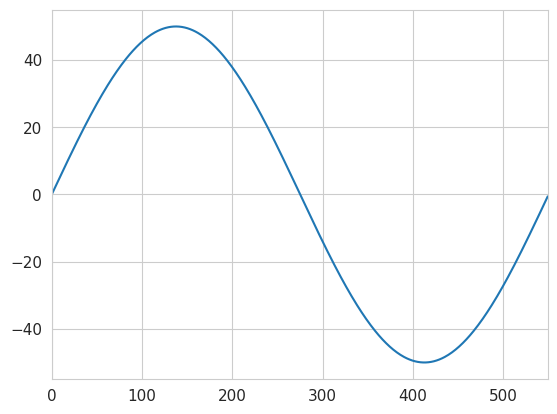

In [15]:
# reference
Ts = 1e-2
#t_CL = np.arange(0, 5, Ts)

s = tf('s')
tau = 1 # s
M = 1/(1 + (tau/(2*np.pi))*s)
M = M*(1 + 1e-2*(tau/(2*np.pi))*s) # add a high freq zero for inversion
T_cl = 5.5
t_CL = np.arange(0, T_cl, Ts)

r = np.zeros(t_CL.shape)
#only one ref should be chosen
steps_1 = 0
steps_10 = 0
steps_100 = 0

ramp1 = 0
ramp10 = 0
ramp100 = 0 
ramp_minus10 = 0
ramp_minus100 = 0 

parabolic1 = 0
parabolic10 = 0
parabolic100 = 0 

sine_1 = 0 # A = 1 , one period
sine_2 = 1 # A = 50 , one period 
sine_3 = 0 # A = 1 , 10 periods
sine_4 = 0 # A =50, 10 periods , 
sine_5 = 0 # A = 1, 4 periods , 
sine_6 = 0 # A = 50 , 4 periods

impulse1 = 0 
impulse10 = 0  
impulse100 = 0



if steps_1 or ramp1 or parabolic1 or sine_1 or sine_3 or sine_5 or impulse1: value = 1
if steps_10 or ramp10 or parabolic10 or impulse10: value = 10
if  sine_2 or sine_4 or sine_6 : value = 50
if steps_100 or ramp100 or parabolic100 or impulse100 : value = 100
if ramp_minus100 : value = -100
if ramp_minus10: value = -10
if sine_1 or sine_2 : freq = 1/T_cl
if sine_3 or sine_4 : freq = 2
if sine_5 or sine_6 : freq = 4/T_cl

if (steps_1 or steps_10 or steps_100) :
    r[t_CL < T_cl/2] = value
    r[(t_CL >= T_cl/2) & (t_CL < T_cl)] = - value

if (ramp1 or ramp10 or ramp100 or ramp_minus100 or ramp_minus10) :
    ramp_up_indices = t_CL <= T_cl/2
    r[ramp_up_indices] = t_CL[ramp_up_indices]*value / T_cl/2
    ramp_down_indices = (t_CL > T_cl/2) & (t_CL <= T_cl)
    r[ramp_down_indices] = (T_cl - t_CL[ramp_down_indices])*value / T_cl/2
    
if ( parabolic1 or parabolic10 or parabolic100 ) :
    ramp_up_indices = t_CL <= T_cl/2
    r[ramp_up_indices] = (t_CL[ramp_up_indices]**2)*value / (T_cl/2**2)
    ramp_down_indices = (t_CL > T_cl/2) & (t_CL <= T_cl)
    r[ramp_down_indices] = ((T_cl - t_CL[ramp_down_indices])**2)*value / (T_cl/2**2)
    
if (sine_1 or sine_2 or sine_3 or sine_4 or sine_5 or sine_6 ):
    r = value * np.sin(2 * np.pi * freq * t_CL)

if( impulse1 or impulse100 or impulse10 ):
    r[((len(t_CL) // 2)-10) : ((len(t_CL) // 2)+10)] = value

plt.plot(r)

In [19]:
n_testing = 1
H = 5

y_log = np.zeros((n_testing,len(t_CL)))
e_log = np.zeros((n_testing,len(t_CL)))
u_log = np.zeros((n_testing,len(t_CL)))

Ts = 1e-2; Fs = 1 / Ts
s = tf('s')
# problem data

with torch.no_grad():
    for n_testing in range(n_testing):#len(data_test)):
        print(n_testing)
        
        e = torch.Tensor([[[]]])
        u = torch.Tensor([[[]]])
        
        # This is like t=0, for our model we need u(-1).
        u_i = 1e-6 # u(-1)
        x1_i = np.array([[1e-6, 1e-6]])  #G1 has 2 states
        x2_i = np.array([[1e-6, 1e-6, 1e-6]]) #G2 has 5 states
        y_i = 1e-6
        
        u_log[n_testing,0] = u_i
        y_log[n_testing,0] = y_i
        
        for i in range(0,len(t_CL)):#batch_u.shape[0]): # for each system
            
            u_i = torch.Tensor([[[u_i]]])   # first you add u(t)
            u = torch.cat((u,u_i / 1),2)    # u dovrebbe essere già normalizzato
            
            e_i = torch.Tensor([[[r[i] - y_i]]]) # e(t)
            e = torch.cat((e,e_i / 1.5),2)  
            
            if i < H:
                pred, _ = model(e.reshape(1,-1,1), u.reshape(1,-1,1))
            else:
                e_tmp = e.reshape(1,-1,1)
                u_tmp = u.reshape(1,-1,1)
                pred, _ = model(e_tmp[:,-H:,:], u_tmp[:,-H:,:])
            
            u_i = pred[:,-1,:].item() * 1 # u(t)
            
            
            ##SOMETHING TO FIX HERE
            #G1
            y1_i, x1_i = dlsim(*G1, u_i, x1_i[-1])
            y1_i = y1_i[-1]
            y1_i = y1_i / 0.83 # nn_fun riceve y1 normalizzato ????
            y1_i = y1_i.reshape(-1, 1)
            
            # F
            y2_i = nn_fun(y1_i)
            #y_2_i = y_2_i.reshape(-1,1)
            y2_i = y2_i[0] # the output of nn_fun needs to be unpacked
            
            # G2
            y3_i, x2_i = dlsim(*G2, y2_i, x2_i[-1])
            y3_i = y3_i[-1]
            
            y_i = y3_i
        
            e_log[n_testing,i] = e_i
            if (i+1) < len(t_CL) :
              u_log[n_testing,i+1] = u_i
              y_log[n_testing,i+1] = y_i

0


/home/rbusetto/.virtualenvs/sysid-transformers-control/lib/python3.10/site-packages/control/timeresp.py:1003: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
/home/rbusetto/.virtualenvs/sysid-transformers-control/lib/python3.10/site-packages/control/timeresp.py:1009: UserWarning: Non-zero initial condition given for transfer function system. Internal conversion to state space used; may not be consistent with given X0.
  warnings.warn(
/home/rbusetto/.virtualenvs/sysid-transformers-control/lib/python3.10/site-packages/scipy/signal/_lti_conversion.py:74: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  num, den = normalize(num, den)   # Strips zeros, checks arrays


In [20]:
print(e_log.shape) 

(1, 550)


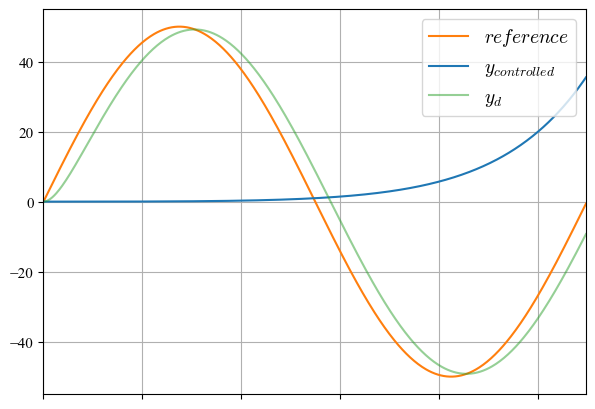

In [21]:
y_d = lsim(M, r,t_CL )[0]


fig = plt.figure(figsize=(7, 5))

plt.plot(t_CL, r, label="$r$", c='tab:orange')
plt.plot(t_CL, y_log.T, label="$y$", c='tab:blue', alpha=1)
plt.plot(t_CL, y_d, label="$y_d$", c='tab:green', alpha= 0.5)
plt.legend(['$reference$','$y_{controlled}$', '$y_{d}$'], loc = 'upper right', prop={'size': 14})
plt.tick_params('x', labelbottom=False)

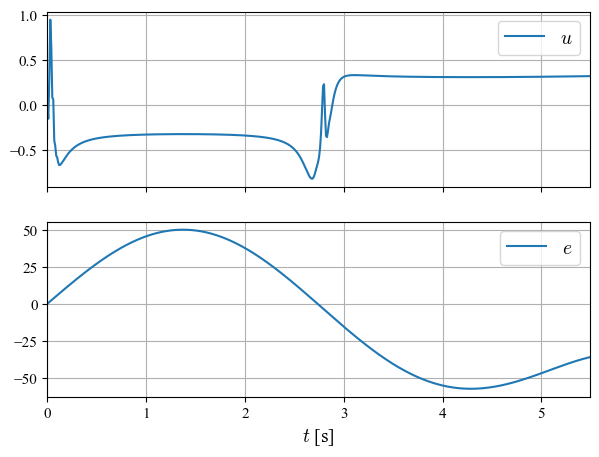

In [22]:
fig = plt.figure(figsize=(7, 5))

plt.subplot(211)
plt.plot(t_CL, u_log.T, c='tab:blue', alpha=1)
plt.legend(['$u$'] , loc = 'upper right', prop={'size': 14})
plt.tick_params('x', labelbottom=False)

plt.subplot(212)
plt.plot(t_CL, e_log.T, c='tab:blue', alpha=1)
plt.xlabel('$t$ [s]')
plt.legend(['$e$'], loc = 'upper right',prop={'size': 14})

# plt.savefig('transformer_controller.pdf')

plt.show()

In [23]:
err = e_log.reshape(-1)

## CALCULATE MSE (r, y) 
error_tot = 0
for k in range(len(err)):
    squared_error = err[k] * err[k]
    error_tot += squared_error 
MSE = error_tot / len(err)
print(f"MSE (r,y) : {MSE:.5f}")
y_log = y_log.reshape(-1)

##CALCULATE MSE ( y_d , y )

Mr_error = y_d - y_log
mr_error_tot = 0
for k in range(len(Mr_error)):
    mr_squared_error = Mr_error[k] * Mr_error[k]
    mr_error_tot += mr_squared_error 
MSE2 = mr_error_tot / len(Mr_error)
print(f"MSE (y_d,y): {MSE2:.5f}")


MSE (r,y) : 1619.14930
MSE (y_d,y): 1622.43034


ValueError: x and y must have same first dimension, but have shapes (550,) and (1, 550)

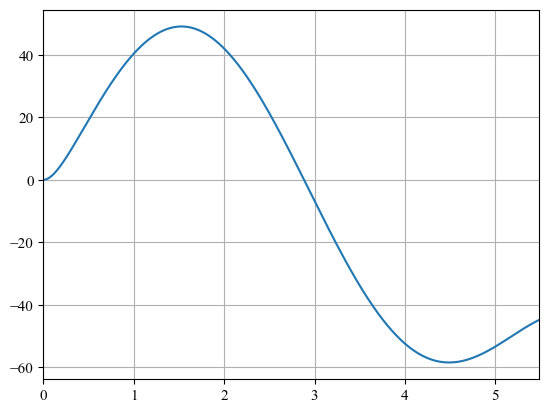

In [24]:
plt.plot(t_CL, Mr_error)
plt.plot(t_CL, e_log, c='tab:orange')
plt.legend(['$MRerror$','$RtoYerror$'])